In [21]:
from pyomo.environ import *
import numpy as np
import matplotlib.pyplot as plt
from random import choices
import folium
from folium.plugins import MarkerCluster
from IPython.display import display, IFrame, HTML
from functions import generate_random_coordinates, create_distance_matrix, plot_nodes, create_map


In [22]:
model = ConcreteModel()

# Indexes

In [23]:
num_of_pick_ups = 15
num_parks = 4
num_out = 1
num_nodes = num_of_pick_ups + num_parks + num_out
num_vehicles = 8
num_timesteps = 96

# Sets

In [24]:
model.N = RangeSet(num_nodes) # set of nodes
#model.S = Set(initialize=[i for i in model.N if i <= num_parks]) # subset of parking spots
#model.O = Set(initialize=[i for i in model.N if num_parks < i <= num_parks + num_out]) # subset of outage locations
model.S = RangeSet(num_parks)
model.O = RangeSet(num_out)
model.S_O = model.S | model.O
model.Others = model.N - model.S - model.O
model.A = Set(dimen=2, initialize=lambda model: [(i, j) for i in model.N for j in model.N if i != j])
model.A_trips = Set(dimen=2, initialize=lambda model: [(i, j) for i in model.Others for j in model.Others if i != j])
model.K = RangeSet(num_vehicles) # set of vehicles
model.T = RangeSet(num_timesteps) # set of timesteps

# Map

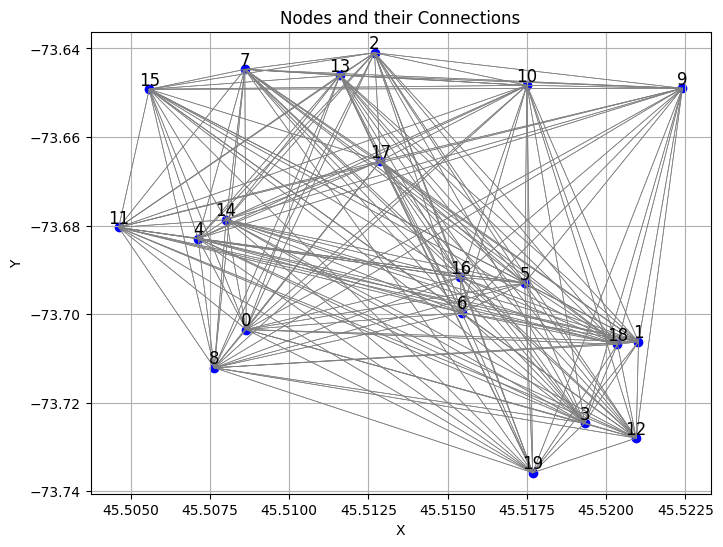

In [25]:
coordinates = generate_random_coordinates(num_nodes)
distance_matrix, _ = create_distance_matrix(num_nodes)
plot_nodes(coordinates)
map = create_map(coordinates)

In [26]:
# Create a map centered around Montreal
montreal_map = folium.Map(location=[45.518157, -73.688946], zoom_start=14.2)

# Add markers for each node
for i, (lat, lon) in coordinates.items():
    folium.Marker([lat, lon], tooltip=f'Node {i}').add_to(montreal_map)

# Display the map in the notebook
HTML(montreal_map._repr_html_())

# Data (artificial)

In [27]:
B = [100] * num_vehicles  # Battery capacity of vehicle k [kWh]
P = np.random.choice([0, 1], size=(num_nodes, num_nodes, num_timesteps), p=[0.95,0.05])
pi_plus = np.random.uniform(0.02, 0.05, size=num_timesteps)  # Price to buy energy (grid) at time t [CA$/kWh]
pi_minus = np.random.uniform(0.01, 0.03, size=num_timesteps)  # Price to sell energy (grid) at time t [CA$/kWh]
pi_out = np.random.uniform(0.015, 0.035, size=num_timesteps)  # Price to sell energy (outage) at time t [CA$/kWh]
alpha = 0.5  # Price paid by each customer per trip [CA$/time]
Z = np.random.randint(0, 2, size=(num_out, num_timesteps))  # Binary parameter indicating if an outage occurs at note o at time t {0,1}
E_req = np.random.randint(80,100,size=(num_out, num_timesteps))  # Energy required in an affected zone o per timestep t [kWh]
gamma_max = 1  # Maximum state-of-charge [%]
gamma_min = 0.2  # Minimum state-of-charge [%]
gamma_0 = np.random.uniform(0.75, 1.0, size=num_vehicles)  # Initial state-of-charge for each vehicle k [%]
tau = ((distance_matrix*1000)/4).astype(int)  # Travel time between node i to node j // average speed: 12 km/h
xi = 0.15  # Energy consumption rate [kWh/km]
rho_plus = 10  # Charging rate (parking spots) [kW]
rho_minus = 10  # Discharging rate (parking spots) [kW]
rho_out = 5  # Discharging rate (outage location) [kW]
eta = 0.9  # Charger efficiency [%]
R_bat = 130  # Battery replacement costs [CA$/kWh]
N_Cy = 3000  # Number of cycles until end-of-life
lambda_DoD = 0.8 # Depth of discharge [%]

# Parameters

In [28]:
model.B = Param(model.K, initialize=lambda model, k: B[k-1])  # Battery capacity of vehicle k [kWh]
model.P = Param(model.N, model.N, model.T, initialize=lambda model, i, j, t: P[i-1, j-1, t-1])  # Number of passengers arriving at node i with destination j at time t
model.pi_plus = Param(model.T, initialize=lambda model, t: pi_plus[t-1])  # Price to buy energy (grid) at time t [CA$/kWh]
model.pi_minus = Param(model.T, initialize=lambda model, t: pi_minus[t-1])  # Price to sell energy (grid) at time t [CA$/kWh]
model.pi_out = Param(model.T, initialize=lambda model, t: pi_out[t-1])  # Price to sell energy (outage) at time t [CA$/kWh]
model.alpha = Param(initialize=alpha)  # Price paid by each customer per trip [CA$/time]
model.Z = Param(model.O, model.T, initialize=lambda model, o, t: Z[o-1, t-1])  # Binary parameter indicating if an outage occurs at note o at time t {0,1}
model.E_req = Param(model.O, model.T, initialize=lambda model, o, t: E_req[o-1, t-1])  # Energy required in an affected zone o per timestep t [kWh]
model.gamma_max = Param(initialize=gamma_max)  # Maximum state-of-charge [%]
model.gamma_min = Param(initialize=gamma_min)  # Minimum state-of-charge [%]
model.gamma_0 = Param(model.K, initialize=lambda model, k: gamma_0[k-1])  # Initial state-of-charge for each vehicle k [%]
model.tau = Param(model.N, model.N, initialize=lambda model, i, j: tau[i-1, j-1])  # Travel time between node i to node j
model.xi = Param(initialize=xi)  # Energy consumption rate [kWh/km]
model.rho_plus = Param(initialize=rho_plus)  # Charging rate (parking spots) [kW]
model.rho_minus = Param(initialize=rho_minus)  # Discharging rate (parking spots) [kW]
model.rho_out = Param(initialize=rho_out)  # Discharging rate (outage location) [kW]
model.eta = Param(initialize=eta)  # Charger efficiency [%]
model.R_bat = Param(initialize=R_bat)  # Battery replacement costs [CA$/kWh]
model.N_Cy = Param(initialize=N_Cy)  # Number of cycles until end-of-life
model.lambda_DoD = Param(initialize=lambda_DoD)  # Depth of discharge [%]

# Variables

In [29]:
model.x = Var(model.K, model.N, model.N, model.T, within=Binary)  # Binary variable indicating if vehicle k is carrying passengers from node i to node j at timestep t {0,1}
model.y = Var(model.K, model.N, model.N, model.T, within=Binary)  # Binary variable indicating if vehicle k is reallocating (empty) from node i to node j at timestep t {0,1}
model.z = Var(model.K, model.N, model.T, within=Binary)  # Binary variable indicating if vehicle k in parked at node i at timestep t {0,1}
model.p = Var(model.K, model.N, model.T, within=Binary)  # Binary variable indicating if vehicle k is arriving at node i at timestep t {0,1}
model.u_plus = Var(model.K, model.S, model.T, within=Binary)  # Binary variable indicating if vehicle k is charging at node s at timestep t {0,1}
model.u_minus = Var(model.K, model.S, model.T, within=Binary)  # Binary variable indicating if vehicle k is discharging at node s at timestep t {0,1}
model.u_out = Var(model.K, model.O, model.T, within=Binary)  # Binary variable indicating if vehicle k is offering energy in affected zone o at time t {0,1}
model.d = Var(model.N, model.N, model.T, within=NonNegativeIntegers)  # Number of passengers waiting at node i with destination j at timestep t
model.e = Var(model.K, model.T, within=NonNegativeReals)  # Energy of vehicle k at timestep t [kWh]
model.g_plus = Var(model.K, model.S, model.T, within=NonNegativeReals)  # Energy charged from vehicle k at node s at timestep t [kWh]
model.g_minus = Var(model.K, model.S, model.T, within=NonNegativeReals)  # Energy discharged from vehicle k at node s at timestep t [kWh]
model.g_out = Var(model.K, model.O, model.T, within=NonNegativeReals)  # Total energy offered from vehicle k to affected zone o at timestep t [kWh]
model.a = Var(model.K, within=NonNegativeReals) # Total energy taken from a vehicle k battery through its lifespan [kWh]
model.w = Var(model.K, model.T, within=NonNegativeReals)  # Battery degradation costs of vehicle k in timestep t to offer energy to the grid [CA$]

# Objective Function

In [30]:
# Objective 1
def obj_rule(model):
    return sum(
        sum(model.alpha * model.tau[i,j] * model.x[k,i,j,t] for k in model.K for (i,j) in model.A) -
        sum(model.w[k,t] + sum(model.g_plus[k,s,t] - model.g_minus[k,s,t] for s in model.S) - sum(model.g_out[k,o,t] for o in model.O) for k in model.K)
        for t in model.T)
model.obj = Objective(rule=obj_rule, sense=maximize)


# Objetive 2
#def obj_rule(model):
#    return sum(
#        sum(model.d[i,j,t] for (i,j) in model.A) +   
#        sum(model.tau[i,j] * model.y[k,i,j,t] for k in model.K for (i,j) in model.A)
#        for t in model.T)
#model.obj = Objective(rule=obj_rule, sense=minimize)


# Constraints

In [31]:
model.constraints = ConstraintList() # Create a set of constraints

# Equation 7
for i,j in model.A:
    for t in range(1,24):
        model.constraints.add(model.d[i,j,t+1] == model.d[i,j,t]+model.P[i,j,t]-sum(model.x[k,i,j,t] for k in model.K))

# Equation 8
for k in model.K:
    for i in model.Others:
        for t in model.T:
            model.constraints.add(model.z[k,i,t] == 0)

# Equation 9
for k in model.K:
    for i in model.N:
        for t in model.T:
            model.constraints.add(model.p[k,i,t] == sum(model.x[k,j,i,t-model.tau[i,j]]+model.y[k,j,i,t-model.tau[i,j]] for (j,i) in model.A if model.tau[i,j]< t))

# Equation 10
for k in model.K:
    for t in model.T:
        model.constraints.add(sum(model.z[k,i,t] + sum(model.x[k,j,i,t] + model.y[k,j,i,t] for i,j in model.A) for i in model.N) <= 1)

# Equation 11
for k in model.K:
    for i in model.N:
        for t in model.T:
            model.constraints.add(model.z[k,i,t] + model.p[k,i,t] <= 1)

# Equation 12
for k in model.K:
    for i in model.N:
        for t in range(1,24):
            model.constraints.add(model.z[k,i,t+1] == model.z[k,i,t]+model.p[k,i,t] - sum(model.x[k,j,i,t] + model.y[k,j,i,t] for i,j in model.A))

# Equation 13
for k in model.K:
    for t in range(1,24):
        model.constraints.add(model.e[k,t+1] == model.e[k,t] + sum(model.eta * model.g_plus[k,s,t] for s in model.S) - sum((1/model.eta) * model.g_minus[k,s,t] for s in model.S) - sum((1/model.eta) * model.g_out[k,o,t] for o in model.O) - (model.xi*(1 - sum(model.z[k,i,t] for i in model.N))))

# Equation 14
for k in model.K:
    for t in model.T:
        model.constraints.add(model.e[k,t] <= model.gamma_max * model.B[k])
        model.constraints.add(model.e[k,t] >= model.gamma_min * model.B[k])

# Equation 15
for k in model.K:
    model.constraints.add(model.e[k,1] == model.gamma_0[k] * model.B[k])

# Equation 16
for k in model.K:
    for s in model.S:
        for t in model.T:
            model.constraints.add(model.g_plus[k,s,t] <= model.rho_plus * model.u_plus[k,s,t])

# Equation 17
for k in model.K:
    for s in model.S:
        for t in model.T:
            model.constraints.add(model.g_minus[k,s,t] <= model.rho_minus * model.u_minus[k,s,t])

# Equation 18
for k in model.K:
    for o in model.O:
        for t in model.T:
            model.constraints.add(model.g_out[k,o,t] <= model.rho_out * model.u_out[k,o,t])

# Equation 19
for k in model.K:
    for i in model.N:
        for s in model.S:
            for o in model.O:
                for t in range(1,24):
                    model.constraints.add(model.u_plus[k,s,t] + model.u_minus[k,s,t] + model.u_out[k,o,t] <= model.z[k,i,t+1])

# Equation 20
for k in model.K:
    for o in model.O:
        for t in model.T:
            model.constraints.add(model.u_out[k,o,t] <= model.Z[o,t])

# Equation 21
for k in model.K:
    for o in model.O:
        for t in model.T:
            model.constraints.add(model.u_plus[k,o,t] + model.u_minus[k,o,t] == 0)

# Equation 22
for o in model.O:
    for t in model.T:
        model.constraints.add(sum(model.g_out[k,o,t] for k in model.K) <= model.E_req[o,t])

# Equation 23
for k in model.K:
    model.constraints.add(model.a[k] == model.N_Cy * model.lambda_DoD * model.B[k])

# Equation 24
for k in model.K:
    for t in model.T:
        model.constraints.add(model.w[k,t]==(model.R_bat/(model.N_Cy * model.lambda_DoD)) * (sum(model.g_minus[k,s,t] for s in model.S) + sum(model.g_out[k,o,t] for o in model.O)))

# epsilon-constraint method
model.constraints.add(sum(sum(model.d[i,j,t] for (i,j) in model.A) + sum(model.tau[i,j] * model.y[k,i,j,t] for k in model.K for (i,j) in model.A) for t in model.T) >= 10)

# Solver

In [ ]:
opt = SolverFactory('gurobi')
opt.options['timelimit'] = 30
opt.options['mipgap'] = 0.001
results = opt.solve(model,tee=True)
print(model.obj())

In [ ]:
import matplotlib.pyplot as plt

# Assuming model.K represents the vehicles and model.T represents the time periods
for k in model.K:
    energy_variation = [value(model.e[k, t]) for t in model.T]
    plt.plot(model.T, energy_variation, label=f'Vehicle {k}')

plt.xlabel('Time Period')
plt.ylabel('Energy Variation')
plt.title('Energy Variation of Each Vehicle')
plt.legend()
plt.grid(True)
plt.show()
